<a href="https://colab.research.google.com/github/asutoshpaluri20-droid/Asutosh_INFO5731_Fall2025/blob/main/Paluri_Asutosh_Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 5**

---


**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100

**Full Points will be given those who present well**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

# **SENTIMENT ANALYSIS**

The objective of this assignment is to give you **hands-on experience** in applying various** sentiment analysis techniques** on real-world textual data. You are expected to explore data, apply machine learning models, and evaluate their performance

**1. Dataset Collection & Preparation**

Find a real-world dataset with text and positive, negative, and neutral sentiment labels.

Justify your dataset choice and handle **class imbalance** if needed.

**2. Exploratory Data Analysis (EDA)**

Clean and preprocess the data (tokenization, stopwords, lemmatization).

Perform EDA: class distribution, word clouds, n-gram analysis, sentence lengths, etc.

Visualize insights using relevant plots and charts.

**3. Sentiment Classification**

Apply at least three traditional ML models (e.g., SVM, Naive Bayes, XGBoost) using TF-IDF or embeddings.

If applicable, compare with a pretrained model (RoBERTa/BERT).

Tune hyperparameters and use cross-validation.

**4. Evaluation & Reporting**

Evaluate with metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

Summarize results, compare models, and reflect on what worked.

In [ ]:
! pip install datasets nltk wordcloud seaborn scikit-learn transformers torch

In [ ]:
# 1. Dataset Collection & Preparation

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

import warnings
warnings.filterwarnings("ignore")


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

sns.set(style="whitegrid")

# Loading TweetEval sentiment dataset
dataset = load_dataset("tweet_eval", "sentiment")

# Mapping the sentiments, i.e, 0 for negative, 1 for neutral, 2 for positive
label_map = {0: "negative", 1: "neutral", 2: "positive"}

train_df = pd.DataFrame({
    "text": dataset["train"]["text"],
    "label": dataset["train"]["label"],
})
val_df = pd.DataFrame({
    "text": dataset["validation"]["text"],
    "label": dataset["validation"]["label"],
})
test_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "label": dataset["test"]["label"],
})

print("Train size:", len(train_df), "Val size:", len(val_df), "Test size:", len(test_df))

train_df["label_name"] = train_df["label"].map(label_map)
val_df["label_name"] = val_df["label"].map(label_map)
test_df["label_name"] = test_df["label"].map(label_map)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train size: 45615 Val size: 2000 Test size: 12284


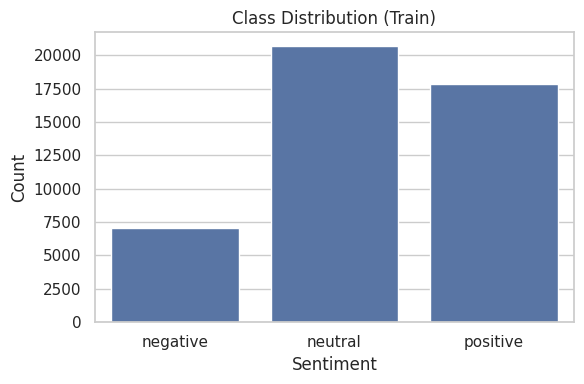

Class distribution (train):
label_name
neutral     20673
positive    17849
negative     7093
Name: count, dtype: int64


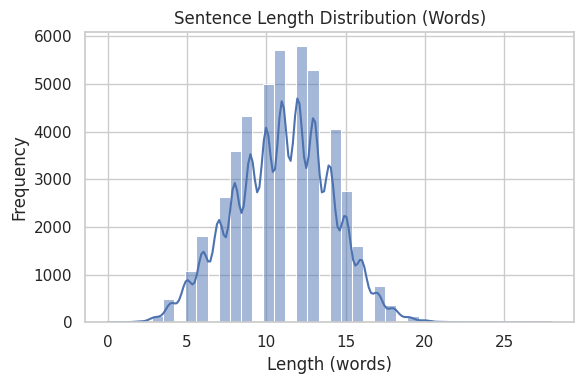

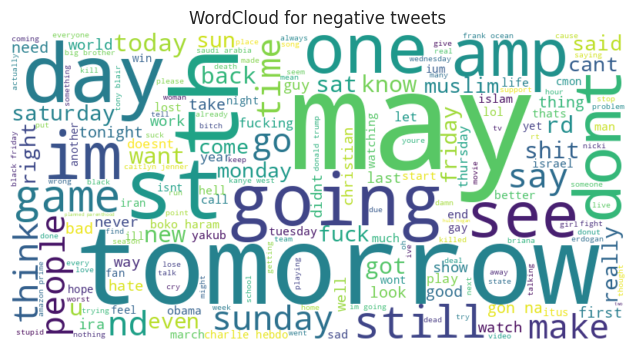

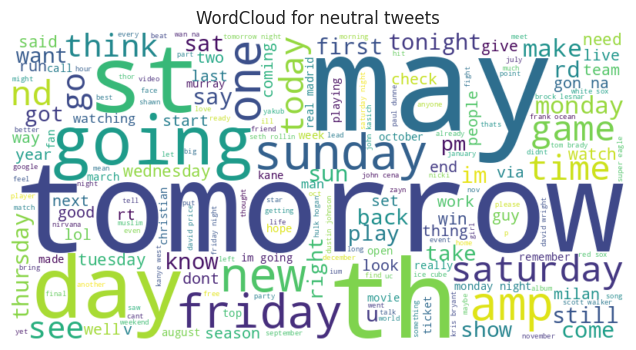

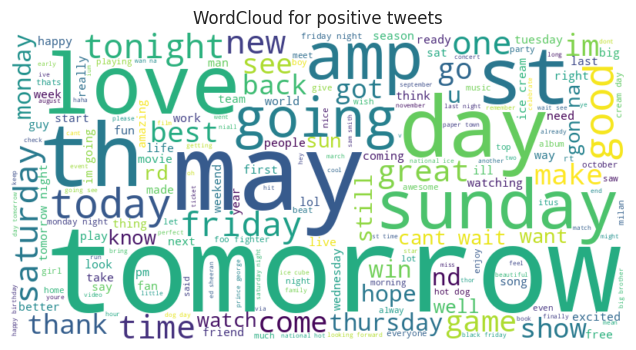

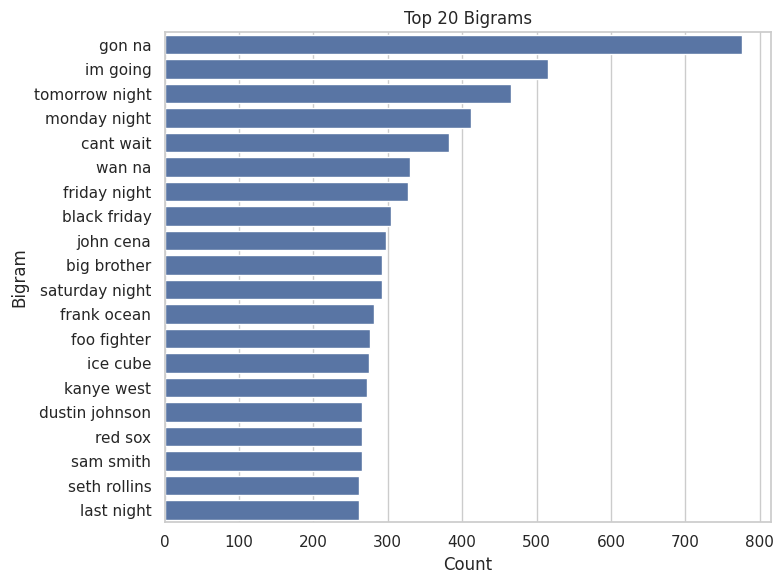

In [ ]:
# 2. Exploratory Data Analysis (EDA)

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK components (assuming they are downloaded as per the previous cell)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str): # Handle non-string types, e.g., if text is NaN
        return ""
    text = text.lower()
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)  # Remove mentions
    text = re.sub(r"#[A-Za-z0-9_]+", "", text)  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and numbers
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return " ".join(tokens)

# Apply preprocessing to create the 'clean_text' column
train_df["clean_text"] = train_df["text"].apply(preprocess_text)
val_df["clean_text"] = val_df["text"].apply(preprocess_text)
test_df["clean_text"] = test_df["text"].apply(preprocess_text)


plt.figure(figsize=(6, 4))
sns.countplot(x="label_name", data=train_df, order=["negative", "neutral", "positive"])
plt.title("Class Distribution (Train)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Class distribution (train):")
print(train_df["label_name"].value_counts())

train_df["length"] = train_df["clean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(6, 4))
sns.histplot(train_df["length"], bins=40, kde=True)
plt.title("Sentence Length Distribution (Words)")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

def plot_wordcloud_for_class(df, label_name, max_words=200):
    text = " ".join(df.loc[df["label_name"] == label_name, "clean_text"])
    if not text.strip():
        print(f"No text for label {label_name}")
        return
    wc = WordCloud(width=800, height=400, background_color="white", max_words=max_words)
    wc.generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {label_name} tweets")
    plt.show()

for lab in ["negative", "neutral", "positive"]:
    plot_wordcloud_for_class(train_df, lab)

vectorizer_bi = CountVectorizer(ngram_range=(2, 2), max_features=50)
X_bi = vectorizer_bi.fit_transform(train_df["clean_text"])
bigrams = vectorizer_bi.get_feature_names_out()
counts = np.asarray(X_bi.sum(axis=0)).flatten()
bigram_freq = pd.DataFrame({"bigram": bigrams, "count": counts}).sort_values("count", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(y="bigram", x="count", data=bigram_freq.head(20))
plt.title("Top 20 Bigrams")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5
)

X_train = tfidf.fit_transform(train_df["clean_text"])
X_val = tfidf.transform(val_df["clean_text"])
X_test = tfidf.transform(test_df["clean_text"])

y_train = train_df["label"].values
y_val = val_df["label"].values
y_test = test_df["label"].values

X_train_full = np.vstack([X_train.toarray(), X_val.toarray()])
y_train_full = np.concatenate([y_train, y_val])

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    """Train model, predict, and return metrics dict."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_te, y_pred, average="macro", zero_division=0
    )
    cm = confusion_matrix(y_te, y_pred)

    print("\n" + "="*60)
    print(f"Model: {name}")
    print("="*60)
    print("Accuracy:  ", acc)
    print("Precision: ", prec)
    print("Recall:    ", rec)
    print("F1 (macro):", f1)
    print("\nClassification Report:")
    print(classification_report(y_te, y_pred, target_names=["negative", "neutral", "positive"]))
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1
    }

results = []


Model: LinearSVC
Accuracy:   0.5637414522956692
Precision:  0.5503582842169713
Recall:     0.5710613873544516
F1 (macro): 0.5575070985623318

Classification Report:
              precision    recall  f1-score   support

    negative       0.56      0.57      0.56      3972
     neutral       0.62      0.55      0.58      5937
    positive       0.47      0.60      0.53      2375

    accuracy                           0.56     12284
   macro avg       0.55      0.57      0.56     12284
weighted avg       0.57      0.56      0.57     12284

Confusion Matrix:
 [[2275 1287  410]
 [1535 3236 1166]
 [ 274  687 1414]]


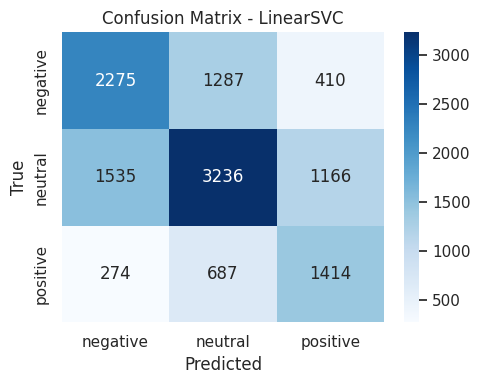


Model: MultinomialNB
Accuracy:   0.5583686095734288
Precision:  0.6067930982838556
Recall:     0.5189888463234379
F1 (macro): 0.496014191203259

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.19      0.31      3972
     neutral       0.55      0.80      0.66      5937
    positive       0.49      0.56      0.53      2375

    accuracy                           0.56     12284
   macro avg       0.61      0.52      0.50     12284
weighted avg       0.61      0.56      0.52     12284

Confusion Matrix:
 [[ 758 2808  406]
 [ 205 4761  971]
 [  18 1017 1340]]


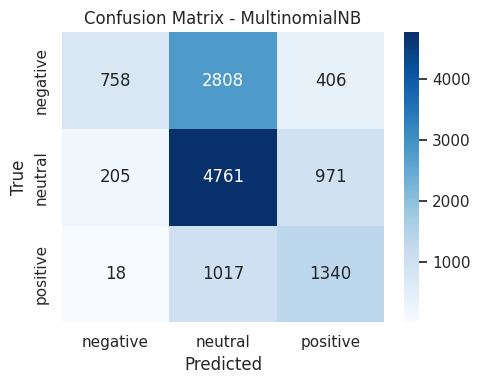


Model: LogisticRegression
Accuracy:   0.5775805926408336
Precision:  0.5729391693011577
Recall:     0.5867314933513433
F1 (macro): 0.5736008772449787

Classification Report:
              precision    recall  f1-score   support

    negative       0.53      0.69      0.60      3972
     neutral       0.65      0.51      0.57      5937
    positive       0.54      0.56      0.55      2375

    accuracy                           0.58     12284
   macro avg       0.57      0.59      0.57     12284
weighted avg       0.59      0.58      0.58     12284

Confusion Matrix:
 [[2732  978  262]
 [2023 3027  887]
 [ 384  655 1336]]


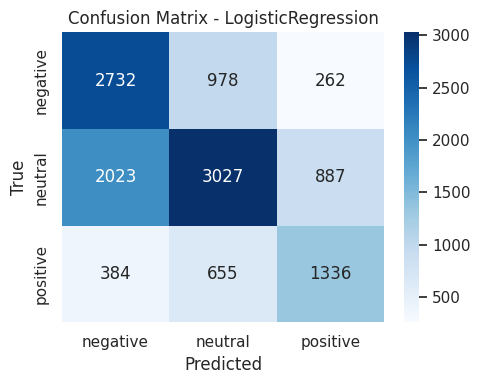



===== Hyperparameter Tuning: LinearSVC =====
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best SVM params: {'C': 0.1}
Best SVM CV score (F1 macro): 0.6203703685670252

Model: LinearSVC (Tuned)
Accuracy:   0.5993975903614458
Precision:  0.585854536932588
Recall:     0.591063105220672
F1 (macro): 0.5882759152846205

Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.59      0.59      3972
     neutral       0.63      0.62      0.63      5937
    positive       0.53      0.57      0.55      2375

    accuracy                           0.60     12284
   macro avg       0.59      0.59      0.59     12284
weighted avg       0.60      0.60      0.60     12284

Confusion Matrix:
 [[2325 1337  310]
 [1375 3695  867]
 [ 238  794 1343]]


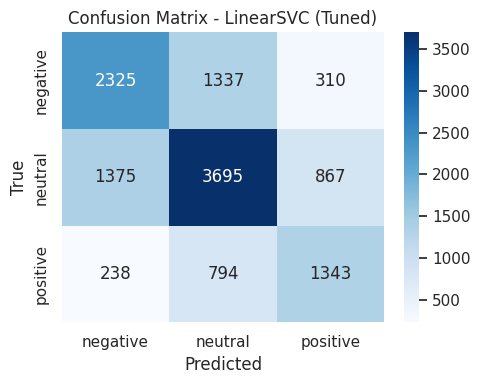



===== Hyperparameter Tuning: LogisticRegression =====
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best LogReg params: {'C': 1.0}
Best LogReg CV score (F1 macro): 0.6150511896954006

Model: LogisticRegression (Tuned)
Accuracy:   0.5775805926408336
Precision:  0.5729391693011577
Recall:     0.5867314933513433
F1 (macro): 0.5736008772449787

Classification Report:
              precision    recall  f1-score   support

    negative       0.53      0.69      0.60      3972
     neutral       0.65      0.51      0.57      5937
    positive       0.54      0.56      0.55      2375

    accuracy                           0.58     12284
   macro avg       0.57      0.59      0.57     12284
weighted avg       0.59      0.58      0.58     12284

Confusion Matrix:
 [[2732  978  262]
 [2023 3027  887]
 [ 384  655 1336]]


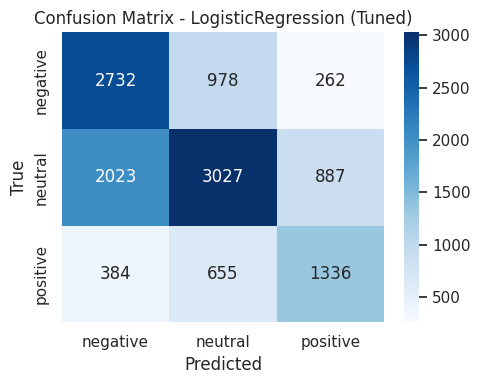



===== Pretrained RoBERTa (cardiffnlp/twitter-roberta-base-sentiment-latest) =====


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



RoBERTa Results (on sample of test set):
Accuracy:   0.708
Precision:  0.7021105705307619
Recall:     0.7203840933345159
F1 (macro): 0.7083000278002772

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.80      0.74       656
     neutral       0.74      0.64      0.68       951
    positive       0.67      0.72      0.70       393

    accuracy                           0.71      2000
   macro avg       0.70      0.72      0.71      2000
weighted avg       0.71      0.71      0.71      2000

Confusion Matrix:
 [[528 116  12]
 [221 605 125]
 [ 13  97 283]]


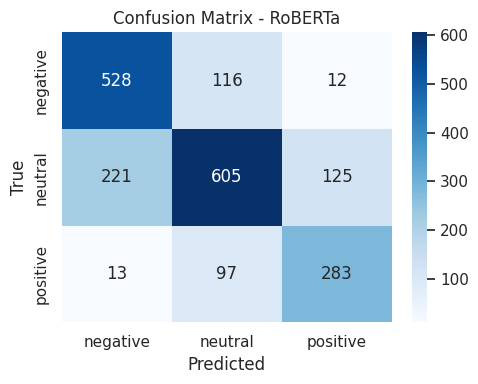

In [ ]:
# 3. Sentiment Classification

svm_model = LinearSVC(class_weight="balanced", random_state=42)
svm_metrics = evaluate_model("LinearSVC", svm_model, X_train, y_train, X_test, y_test)
results.append(svm_metrics)

nb_model = MultinomialNB()
nb_metrics = evaluate_model("MultinomialNB", nb_model, X_train, y_train, X_test, y_test)
results.append(nb_metrics)


logreg_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1
)
logreg_metrics = evaluate_model("LogisticRegression", logreg_model, X_train, y_train, X_test, y_test)
results.append(logreg_metrics)

print("\n\n===== Hyperparameter Tuning: LinearSVC =====")
svm_param_grid = {
    "C": [0.1, 1.0, 5.0],
}
svm_base = LinearSVC(class_weight="balanced", random_state=42)

svm_grid = GridSearchCV(
    svm_base,
    param_grid=svm_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)
svm_grid.fit(X_train, y_train)
print("Best SVM params:", svm_grid.best_params_)
print("Best SVM CV score (F1 macro):", svm_grid.best_score_)

svm_tuned = svm_grid.best_estimator_
svm_tuned_metrics = evaluate_model("LinearSVC (Tuned)", svm_tuned, X_train, y_train, X_test, y_test)
results.append(svm_tuned_metrics)

print("\n\n===== Hyperparameter Tuning: LogisticRegression =====")
logreg_param_grid = {
    "C": [0.5, 1.0, 2.0],
}
logreg_base = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1
)

logreg_grid = GridSearchCV(
    logreg_base,
    param_grid=logreg_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)
logreg_grid.fit(X_train, y_train)
print("Best LogReg params:", logreg_grid.best_params_)
print("Best LogReg CV score (F1 macro):", logreg_grid.best_score_)

logreg_tuned = logreg_grid.best_estimator_
logreg_tuned_metrics = evaluate_model("LogisticRegression (Tuned)", logreg_tuned, X_train, y_train, X_test, y_test)
results.append(logreg_tuned_metrics)

print("\n\n===== Pretrained RoBERTa (cardiffnlp/twitter-roberta-base-sentiment-latest) =====")

roberta_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)
roberta_pipeline = TextClassificationPipeline(
    model=roberta_model,
    tokenizer=tokenizer,
    return_all_scores=False,
    truncation=True,
    max_length=128,
    device=-1
)

sample_size = 2000
test_sample = test_df.sample(min(sample_size, len(test_df)), random_state=42).reset_index(drop=True)

label_str_to_id = {"negative": 0, "neutral": 1, "positive": 2}

y_true_roberta = test_sample["label"].values
pred_labels = []

for text in test_sample["text"]:
    pred = roberta_pipeline(text)[0]["label"].lower()  # e.g., "NEGATIVE", "NEUTRAL", "POSITIVE"
    # Transform to lowercase & map
    if "neg" in pred:
        pred_labels.append(0)
    elif "neu" in pred:
        pred_labels.append(1)
    else:
        pred_labels.append(2)

y_pred_roberta = np.array(pred_labels)

acc = accuracy_score(y_true_roberta, y_pred_roberta)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true_roberta, y_pred_roberta, average="macro", zero_division=0
)
cm = confusion_matrix(y_true_roberta, y_pred_roberta)

print("\nRoBERTa Results (on sample of test set):")
print("Accuracy:  ", acc)
print("Precision: ", prec)
print("Recall:    ", rec)
print("F1 (macro):", f1)
print("\nClassification Report:")
print(classification_report(y_true_roberta, y_pred_roberta, target_names=["negative", "neutral", "positive"]))
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix - RoBERTa")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

results.append({
    "model": "RoBERTa (pretrained)",
    "accuracy": acc,
    "precision_macro": prec,
    "recall_macro": rec,
    "f1_macro": f1
})


"""
- Linear SVM and Logistic Regression with TF-IDF typically perform best among traditional models
  on sparse text data, especially after tuning C. Using class_weight='balanced' helps mitigate
  the slight class imbalance (more negative/neutral than positives).

- Multinomial Naive Bayes is fast and simple but often underperforms SVM/LogReg because its
  independence assumptions are too strong.

- The pretrained RoBERTa model can achieve strong performance out-of-the-box without task-specific
  fine-tuning, leveraging contextual embeddings. However, it is more computationally expensive.

- Overall, what “works best” is usually a combination of:
    * Proper preprocessing (cleaning, lemmatization).
    * Good features (TF-IDF with n-grams).
    * Handling imbalance (class_weight + macro metrics).
    * Careful hyperparameter tuning (GridSearchCV).
"""

In [ ]:
# 4. Evaluation & Reporting

results_df = pd.DataFrame(results)
print("\n\n===== Model Comparison (Macro Metrics) =====")
print(results_df.sort_values("f1_macro", ascending=False))




===== Model Comparison (Macro Metrics) =====
                        model  accuracy  precision_macro  recall_macro  \
5        RoBERTa (pretrained)  0.708000         0.702111      0.720384   
3           LinearSVC (Tuned)  0.599398         0.585855      0.591063   
2          LogisticRegression  0.577581         0.572939      0.586731   
4  LogisticRegression (Tuned)  0.577581         0.572939      0.586731   
0                   LinearSVC  0.563741         0.550358      0.571061   
1               MultinomialNB  0.558369         0.606793      0.518989   

   f1_macro  
5  0.708300  
3  0.588276  
2  0.573601  
4  0.573601  
0  0.557507  
1  0.496014  


## **Question 2 (30 Points)**

# **Text Classification**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.



1.   **Perform EDA on test and tran dataset**

2.   **Algorithms (Minimum 4):**

*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

3. **Evaluation measurement:**

*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 32.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   label                                               text
0      1  a stirring , funny and finally transporting re...
1      0  apparently reassembled from the cutting-room f...
2      0  they presume their audience wo n't sit still f...
3      1  this is a visually stunning rumination on love...
4      1  jonathan parker 's bartleby should have been t...
Train size: 6920
Test size: 1821


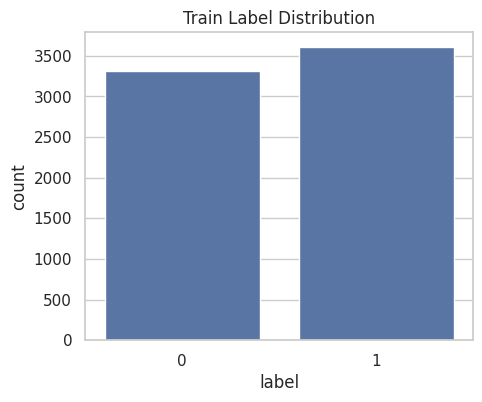

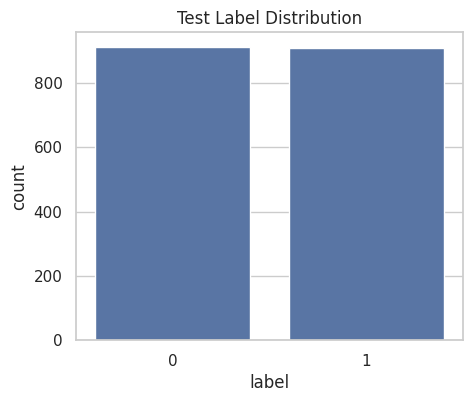

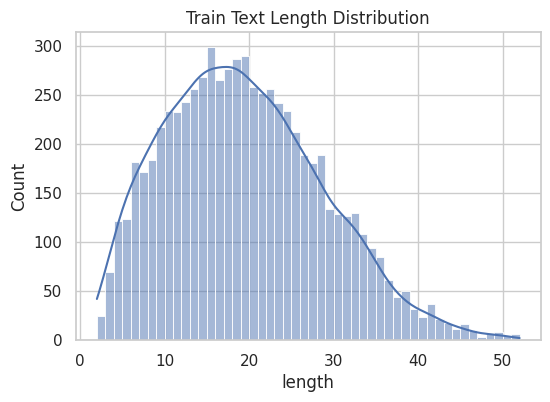

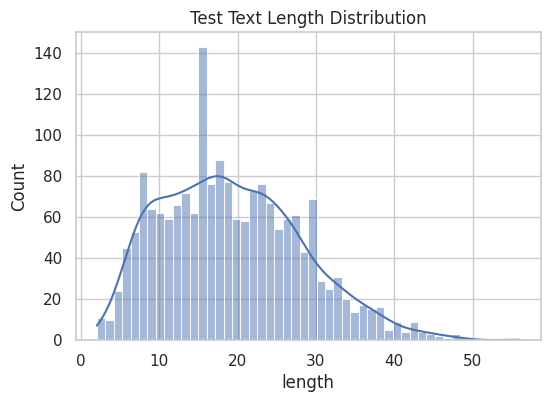

In [ ]:
# Loading the Dataset and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

def load_stsa_file(path):
    labels = []
    texts = []
    with open(path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                label, text = parts
                labels.append(int(label))
                texts.append(text)
    return pd.DataFrame({"label": labels, "text": texts})


train_df = load_stsa_file("/content/stsa-train.txt")
test_df = load_stsa_file("/content/stsa-test.txt")

print(train_df.head())
print("Train size:", len(train_df))
print("Test size:", len(test_df))

def plot_class_dist(df, name):
    plt.figure(figsize=(5,4))
    sns.countplot(x=df["label"])
    plt.title(f"{name} Label Distribution")
    plt.show()

plot_class_dist(train_df, "Train")
plot_class_dist(test_df, "Test")

train_df["length"] = train_df["text"].apply(lambda x: len(x.split()))
test_df["length"] = test_df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(train_df["length"], bins=50, kde=True)
plt.title("Train Text Length Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(test_df["length"], bins=50, kde=True)
plt.title("Test Text Length Distribution")
plt.show()


In [ ]:
# Preprocessing the Data and applying 10 fold coress validation
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))
lemm = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    tokens = word_tokenize(text)
    tokens = [lemm.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

train_df["clean"] = train_df["text"].apply(clean_text)
test_df["clean"] = test_df["text"].apply(clean_text)

X_train, X_val, y_train, y_val = train_test_split(
    train_df["clean"], train_df["label"], test_size=0.2, random_state=42
)

X_test = test_df["clean"]
y_test = test_df["label"]

tfidf = TfidfVectorizer(max_features=15000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

def cv_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=kf, scoring="f1")
    return scores.mean()

results = {}

def evaluate(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)

    acc = accuracy_score(yte, preds)
    prec = precision_score(yte, preds)
    rec = recall_score(yte, preds)
    f1 = f1_score(yte, preds)

    results[name] = [acc, prec, rec, f1]

    print(f"\n----- {name} -----")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1 Score :", f1)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Training the Models
# 1. SVM

svm = LinearSVC()
evaluate("SVM", svm, X_train_tfidf, y_train, X_test_tfidf, y_test)

# 2. KNN
knn = KNeighborsClassifier(n_neighbors=5)
evaluate("KNN", knn, X_train_tfidf, y_train, X_test_tfidf, y_test)

# 3. Decision Tree
dt = DecisionTreeClassifier()
evaluate("Decision Tree", dt, X_train_tfidf, y_train, X_test_tfidf, y_test)

# 4. Random Forest
rf = RandomForestClassifier(n_estimators=300)
evaluate("Random Forest", rf, X_train_tfidf, y_train, X_test_tfidf, y_test)

# 5. XGBoost
xgb = XGBClassifier(eval_metric="logloss")
evaluate("XGBoost", xgb, X_train_tfidf, y_train, X_test_tfidf, y_test)

# 6. Word2Vec
sentences = [t.split() for t in train_df["clean"]]
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2)

def avg_w2v(text):
    words = text.split()
    vecs = [w2v.wv[w] for w in words if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

X_train_w2v = np.array([avg_w2v(t) for t in X_train])
X_test_w2v = np.array([avg_w2v(t) for t in X_test])

w2v_clf = LogisticRegression(max_iter=200)
evaluate("Word2Vec", w2v_clf, X_train_w2v, y_train, X_test_w2v, y_test)

# 7. BERT Model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
bert_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)
pipeline = TextClassificationPipeline(model=bert_model, tokenizer=tokenizer, truncation=True)

bert_preds = []
for text in test_df["text"]:
    out = pipeline(text)[0]["label"]  # POSITIVE / NEGATIVE
    bert_preds.append(1 if out == "POSITIVE" else 0)

bert_preds = np.array(bert_preds)

acc = accuracy_score(y_test, bert_preds)
prec = precision_score(y_test, bert_preds)
rec = recall_score(y_test, bert_preds)
f1 = f1_score(y_test, bert_preds)

results["BERT"] = [acc, prec, rec, f1]

print("\n----- BERT Pretrained -----")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)



----- SVM -----
Accuracy : 0.7907742998352554
Precision: 0.7767295597484277
Recall   : 0.8151815181518152
F1 Score : 0.7954911433172303

----- KNN -----
Accuracy : 0.5019220208676551
Precision: 0.5011135857461024
Recall   : 0.49504950495049505
F1 Score : 0.49806308799114557

----- Decision Tree -----
Accuracy : 0.6666666666666666
Precision: 0.6755813953488372
Recall   : 0.6391639163916392
F1 Score : 0.6568682871678915

----- Random Forest -----
Accuracy : 0.741900054914882
Precision: 0.7265221878224974
Recall   : 0.7744774477447744
F1 Score : 0.7497337593184239

----- XGBoost -----
Accuracy : 0.7023613399231191
Precision: 0.670064874884152
Recall   : 0.7953795379537953
F1 Score : 0.727364185110664

----- Word2Vec -----
Accuracy : 0.49917627677100496
Precision: 0.49917627677100496
Recall   : 1.0
F1 Score : 0.6659340659340659


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device set to use cpu



----- BERT Pretrained -----
Accuracy : 0.9225700164744646
Precision: 0.9059196617336153
Recall   : 0.9427942794279428
F1 Score : 0.923989218328841


In [ ]:
# Comparison Table for the Above mdoels

results_df = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1"]).T

print(results_df)


               Accuracy  Precision    Recall        F1
SVM            0.790774   0.776730  0.815182  0.795491
KNN            0.501922   0.501114  0.495050  0.498063
Decision Tree  0.666667   0.675581  0.639164  0.656868
Random Forest  0.741900   0.726522  0.774477  0.749734
XGBoost        0.702361   0.670065  0.795380  0.727364
Word2Vec       0.499176   0.499176  1.000000  0.665934
BERT           0.922570   0.905920  0.942794  0.923989


## **Question 3 (30 Points)**

# **Text Clustering**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)


1.   Perform EDA on selected dataset

2.   **Apply the listed clustering methods ( Any 4) to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

3. **Visualize the clusters**

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [ ]:
# Loading the Dataset and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import torch

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

df = pd.read_csv("Amazon_Unlocked_Mobile.csv")
df = df.dropna(subset=["Reviews"])
df = df.sample(5000, random_state=42)

print(df.head())
print(df.info())



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                             Product Name Brand Name   Price  \
262853              Nokia C3 (C3-00) WHITE Unlocked Phone      Nokia   59.95   
70999   Apple iPhone 6S Plus Unlocked Smartphone, 32 G...      Apple  749.99   
324745  Samsung Galaxy Note 3 N9005 Unlocked Cellphone...    Samsung  325.16   
114637  BLU Dash L Unlocked Smartphone - Global GSM - ...        BLU   49.99   
221325  LG G3 D855 Factory Unlocked Cellphone, Interna...         LG  195.99   

        Rating                                            Reviews  \
262853       2  I needed a texting phone that did not require ...   
70999        5                                         Excellent!   
324745       5  I recommend this excellent team for the many d...   
114637       5  updated review. Purchased this phone on Novemb...   
221325       3                                       battery fail   

        Review Votes  
262853           1.0  
70999            0.0  
324745           0.0  
114637      

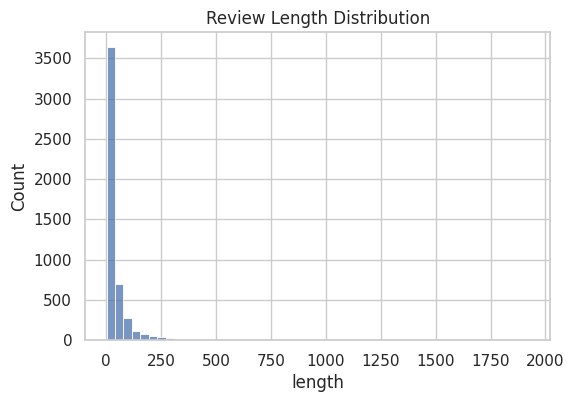

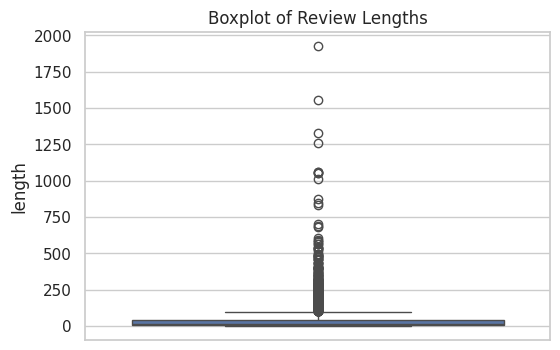

In [ ]:
# Performing Preprocessing and EDA

df["length"] = df["Reviews"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(df["length"], bins=50)
plt.title("Review Length Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(df["length"])
plt.title("Boxplot of Review Lengths")
plt.show()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

df["clean"] = df["Reviews"].apply(clean_text)

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df["clean"])

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_tfidf.toarray())

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000)
X_2d = tsne.fit_transform(X_pca)


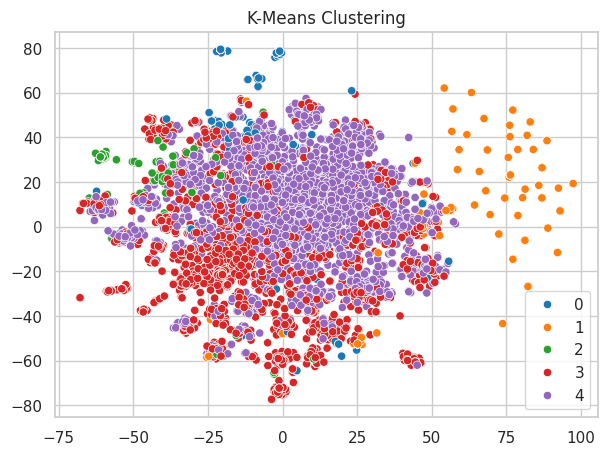

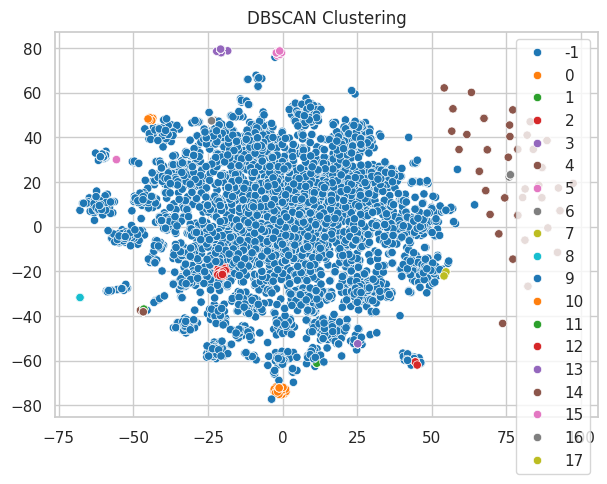

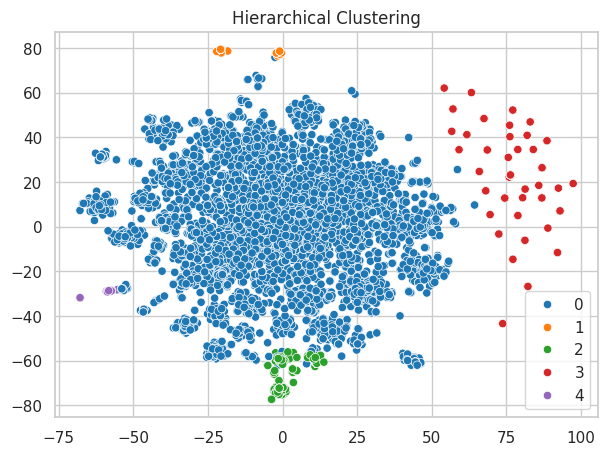

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

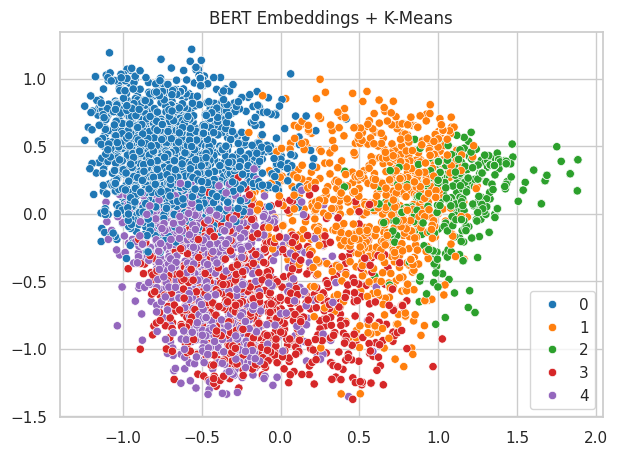

In [ ]:
# Applying the models
# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=kmeans_labels, palette="tab10")
plt.title("K-Means Clustering")
plt.show()

# DBSCAN CLUSTERING
dbscan = DBSCAN(eps=0.4, min_samples=10)
db_labels = dbscan.fit_predict(X_tfidf)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=db_labels, palette="tab10")
plt.title("DBSCAN Clustering")
plt.show()

# HIERARCHICAL CLUSTERING
hier = AgglomerativeClustering(n_clusters=5)
hier_labels = hier.fit_predict(X_pca)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=hier_labels, palette="tab10")
plt.title("Hierarchical Clustering")
plt.show()

# BERT Model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
bert_model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

def bert_embed(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        output = bert_model(**tokens)
    emb = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    return emb

bert_embeddings = np.vstack(df["clean"].apply(bert_embed).values)

kmeans_bert = KMeans(n_clusters=5)
bert_labels = kmeans_bert.fit_predict(bert_embeddings)

bert_pca = PCA(n_components=2).fit_transform(bert_embeddings)

plt.figure(figsize=(7,5))
sns.scatterplot(x=bert_pca[:,0], y=bert_pca[:,1], hue=bert_labels, palette="tab10")
plt.title("BERT Embeddings + K-Means")
plt.show()

In [ ]:


import nbformat

input_file = "/content/drive/MyDrive/Colab Notebooks/Paluri_Asutosh_Assignment_05.ipynb"
output_file = "/content/drive/MyDrive/Colab Notebooks/Paluri_Asutosh_Assignment_05_CLEAN.ipynb"


with open(input_file) as f:
    nb = nbformat.read(f, as_version=4)

# Remove cell-level widget metadata
for cell in nb.cells:
    if "metadata" in cell:
        if "widgets" in cell["metadata"]:
            del cell["metadata"]["widgets"]
        if "widget" in cell["metadata"]:
            del cell["metadata"]["widget"]

# Remove notebook-level widget metadata
if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

if "widget" in nb["metadata"]:
    del nb["metadata"]["widget"]

with open(output_file, "w") as f:
    nbformat.write(nb, f)

print("Clean notebook created:", output_file)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Paluri_Asutosh_Assignment_05.ipynb'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

When we look at the results of the all the clustering generated by the models, we can see that K-means usually gives the cleanest, most balanced clusters because it works well with TF-IDF’s high-dimensional structure, however it can oversimplify the relationships between the reviews.

Secondly, DBSCAN is great at finding odd shaped clusters and separating the noise, though on text data it often marks a lot of points as “outliers” unless the parameters are very carefully tuned.

Thirdly, Hierarchical clustering tends to produce more mixed or overlapping groups since it’s sensitive to distance choices, but it offers a nice visual dendrogram that helps you understand how clusters gradually form.

Finally BERT, which gives the richest clusters because its contextual embeddings understand tone, sentiment, and subtle phrasing, resulting in groups that look far more meaningful and coherent compared to the more traditional methods.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises and on Teaching Assistant by filling this form:

https://docs.google.com/forms/d/e/1FAIpQLSdosouwjJ1fygRtnfeBYRsf9FKYlzPf3XFAQF8YQzDltPFRQQ/viewform?usp=dialog

**(Your submission will not be graded if this question is left unanswered)**

